In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
# from skimage import io
from PIL import Image
# import seaborn as sns
# import cv2

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
data_type = 'train' 

src_root = '/opt/ml/finalproject/data/' + data_type
# src_file = src_root + '/resampled_errordel_'+ data_type +'.json'
src_file = src_root + "/coco_astrophysics.json"
src_desc = data_type # a name (identifier) for the dataset

coco_obj = COCO(src_file)

loading annotations into memory...
Done (t=6.51s)
creating index...
index created!


In [3]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

In [4]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]

print('Dataset Name: ',src_desc)
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Dataset Name:  train
Number of images:  137708
Number of bounding boxes:  377397
Number of classes:  38
Max min avg height:  1080 1080 1080
Max min avg width:  1920 1920 1920


# 이미지 당 객체 개수

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


no obejct image number:  0
{2: 39269, 5: 25383, 4: 21714, 1: 41291, 3: 5680, 6: 3872, 8: 14, 7: 479, 11: 2, 10: 2, 9: 2}


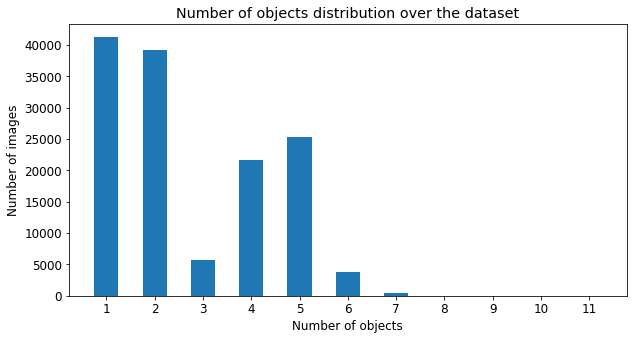

Number of images having atleast one box:  11
Min number of boxes per image:  2
Max number of boxes per image:  41291
Avg number of boxes per image:  12518


In [5]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

no_object_list = []
for i in root['images']:
    a = coco_obj.getAnnIds(imgIds=i['id'])
    img2nboxes.setdefault(len(a), 0)
    img2nboxes[len(a)] += 1

    if len(a) == 0:
        no_object_list.append(i['path']+i['file_name'])
        # print(i['id'], no_object_list)

print('no obejct image number: ',len(no_object_list))
# print(no_object_list)

if len(no_object_list)>10:
    no_object_list = no_object_list[:10]

# 객체 없는 이미지 출력        
if no_object_list:
    n_rows = 1
    n_cols = len(no_object_list)
    fig = plt.figure(figsize=(20,10))
    for i, img_path in enumerate(no_object_list):
        image = Image.open(src_root+img_path)
        ax = fig.add_subplot(1,len(no_object_list), i+1)
        # ax.set_title(img_path, fontsize = 10)
        plt.axis('off')
        plt.imshow(image)
    # plt.tight_layout()
    plt.show()

# print(img2nboxes)

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

print(img2nboxes)

plt.figure(figsize=(10,5))
plt.bar(list(img2nboxes.keys()), list(img2nboxes.values()), tick_label=[str(i) for i in img2nboxes.keys()], width=0.5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show() 

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

# 클래스 개수 분포

    id                           name  count
9   17                        Lighter  32615
6   30           SupplymentaryBattery  31920
22  26                     SmartPhone  31048
4   15                          Knife  29688
2   24                       Scissors  21858
15  23                            Saw  16792
5   28                        Spanner  14185
7    9                            Gun  14172
10  37                         Chisel  14109
23  33                            USB  13871
21  13                            HDD  12721
27   8                    Firecracker  11664
26  10                       GunParts  11350
1    4                            Axe  11206
16  11                         Hammer  10960
11  25                    Screwdriver  10557
3   36                          Plier   9103
24   3                            Awl   7919
19  20                      MetalPipe   7106
33  18                         Liquid   7105
32   7                         Bullet   6808
25  21    

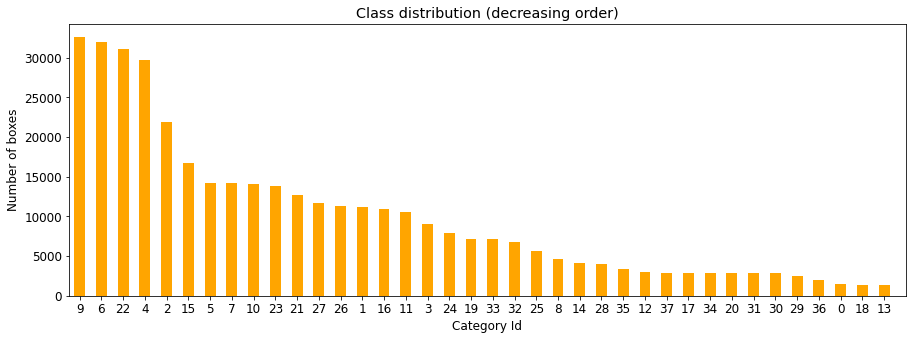

In [6]:
# Class distribution
cat = {x['id']: x['name'] for x in root['categories']}
# print(list(cat.values())[30:])
df = pd.DataFrame(list(cat.items()), columns=['id', 'name']) #.set_index('id')

count = []
for i in coco_obj.getCatIds():
    count.append(len(coco_obj.getAnnIds(catIds=i)))
df['count'] = count

df = df.sort_values(by='count', ascending=False)
print(df)

# print(df['name'])

# # to plot
y = list(df['count'])
x = list(df.index)

plt.figure(figsize=(15,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()

# 이미지 bbox 시각화

### 랜덤 이미지

Astrophysics\ZippoOil\Multiple_Other\H_2707.99-1000_01_108.png
['ZippoOil', 'ZippoOil']


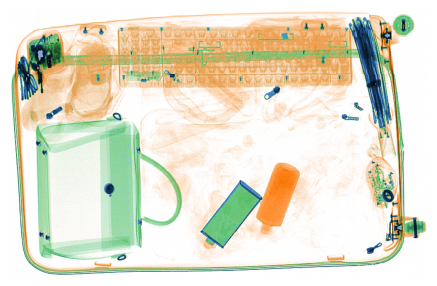

In [7]:
# generate a random image
# np.random.seed(1004)
imgIds = [i['id'] for i in root['images']]
catIds = [i['id'] for i in root['categories']]
# img = coco_obj.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img = coco_obj.loadImgs(imgIds[0])[0]

# img_path= os.path.join(src_root, img['path'][1:], img['file_name'])

# origin train json data (coco_astrophysics.json)
img_dir = img['path'][8:]
print(img_dir)
img_path= os.path.join(src_root, img_dir.replace("\\","/"))

I = Image.open(img_path)

# plot annotations
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(I)
annIds = coco_obj.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_obj.loadAnns(annIds)
coco_obj.showAnns(anns, draw_bbox=True)
classes = [cat[a['category_id']] for a in anns]
print(classes)

### 원본데이터 / Multiple_Categories / Multiple_Other / Single_Default / Single_Other

원본데이터와 각 분포는 다르나 4가지 카테고리의 분포는 동일하다. 

In [8]:
img_id = coco_obj.getImgIds()

multi_origin = []
multi_other = []
single_origin = []
single_other = []

for i in img_id:
    path = root['images'][i-1]['path']
    # a = path.split('/')
    a = path.split("\\")
    
    # category = a[2]
    # sub_cat = a[3]
    category = a[3]
    sub_cat = a[4]
    # print(category, sub_cat)
    
    if sub_cat == 'Multiple_Categories':
        multi_origin.append(category)
    elif sub_cat == "Multiple_Other":
        multi_other.append(category)
    elif sub_cat == "Single_Default":
        single_origin.append(category)
    else:
        single_other.append(category)
    

In [9]:
li = [multi_origin, multi_other, single_origin, single_other]
for d in li:
    print(len(d))
    
print(df["count"].sum())

55048
41314
20669
20677
377397


In [17]:
multi = {}
multi_o = {}
single = {}
single_o = {}

for i in multi_origin:
    try: multi[i] += 1
    except: multi[i] = 1
    
for i in multi_other:
    try: multi_o[i] += 1
    except: multi_o[i] = 1
    
for i in single_origin:
    try: single[i] += 1
    except: single[i] = 1
    
for i in single_other:
    try: single_o[i] += 1
    except: single_o[i] = 1

df_sub = pd.DataFrame(list(multi.items()), columns = ["name", "multi"])
df_sub["multi_o"] = multi_o.values()
df_sub["single"] = single.values()
df_sub["single_o"] = single_o.values()


df_m = df.merge(df_sub, how = "left", left_on = "name", right_on = "name")
df_m["count_percent"] = df_m["count"]/377397
df_m["multi_percent"] = df_m["multi"]/55048
df_m["multi_o_percent"] = df_m["multi_o"]/41314
df_m["single_percent"] = df_m["single"]/20669
df_m["single_o_percent"] = df_m["single_o"]/20677
# df_m

In [20]:
print(len(multi.keys()), len(multi_o.keys()), len(single.keys()), len(single_o.keys()))

39 39 39 39


<AxesSubplot:>

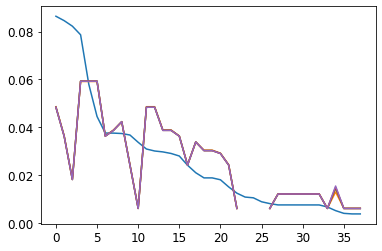

In [19]:
import matplotlib.pyplot as plt

ta = df_m["count_percent"] # 전체 카테고리 분포
tm = df_m["multi_percent"] # multi_categories 분포
tmo = df_m["multi_o_percent"] # multi_other 분포
ts = df_m["single_percent"] # single_default 분포
tso = df_m["single_o_percent"] # single_other 분포

ta.plot()
tm.plot()
tmo.plot()
ts.plot()
tso.plot()